In [43]:
import geopandas as gpd

fp = "L4_data/TravelTimes_to_5975375_RailwayStation.shp"

# Read the GeoJSON file similarly as Shapefile
acc = gpd.read_file(fp)

# Let's see what we have
print(acc.value_counts())

AttributeError: 'GeoDataFrame' object has no attribute 'value_counts'

In [44]:
#Include only data that is above or equal to 0

acc= acc.loc[acc["pt_m_t"]>=0]




In [45]:
import pysal as ps

#define the number of classes
n_classes= 9

#Create a Natural Breaks classifier 
classifier= ps.Natural_Breaks.make(k=n_classes)



In [46]:
classifications= acc[['pt_r_tt']].apply(classifier)

classifications.head()

,pt_r_tt
0,8
1,8
2,8
3,8
4,8


In [47]:
classifications.columns= ["nb_pt_r_tt"]

acc= acc.join(classifications)

#Lets see how our data looks like 
acc.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,geometry,nb_pt_r_tt
0,32297,43,32260,48,5785640,32616,116,147,32616,108,139,5975375,32164,459,"POLYGON ((382000.000 6697750.000, 381750.000 6...",8
1,32508,43,32471,49,5785641,32822,119,145,32822,111,133,5975375,29547,422,"POLYGON ((382250.000 6697750.000, 382000.000 6...",8
2,30133,50,31872,56,5785642,32940,121,146,32940,113,133,5975375,29626,423,"POLYGON ((382500.000 6697750.000, 382250.000 6...",8
3,32690,54,34429,60,5785643,33233,125,150,33233,117,144,5975375,29919,427,"POLYGON ((382750.000 6697750.000, 382500.000 6...",8
4,31872,42,31834,48,5787544,32127,109,126,32127,101,121,5975375,31674,452,"POLYGON ((381250.000 6697500.000, 381000.000 6...",8


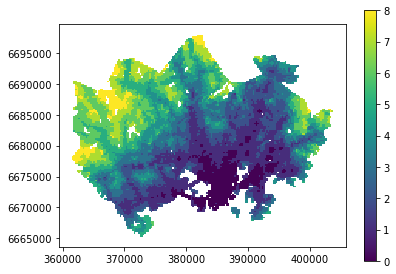

In [50]:
acc.plot(column="nb_pt_r_tt", linewidth=0, legend=True)

# Use tight layout
plt.tight_layout()

In [22]:
#binally classfication 
#市内から20分以内かつ4000m以内で移動できる場所の算出
def custom_classifier(row, src_col1, src_col2, threshold1, threshold2, output_col):
    if row[src_col1]< threshold1 and row[src_col2] > threshold2:
        row[output_col]=1
        
    else:
        row[output_col]= 0
    return row




In [23]:
acc["suitable_area"]= None

#"Use the function we created"
acc= acc.apply(custom_classifier, src_col1="pt_r_tt",
              src_col2='walk_d', threshold1=20, threshold2= 4000,
              output_col="suitable_area", axis=1)

acc.head(2)

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,geometry,nb_pt_r_tt,suitable_area
0,32297,43,32260,48,5785640,32616,116,147,32616,108,139,5975375,32164,459,"POLYGON ((382000.000 6697750.000, 381750.000 6...",8,0
1,32508,43,32471,49,5785641,32822,119,145,32822,111,133,5975375,29547,422,"POLYGON ((382250.000 6697750.000, 382000.000 6...",8,0


In [24]:
acc["suitable_area"].value_counts()

0    13011
1        9
Name: suitable_area, dtype: int64

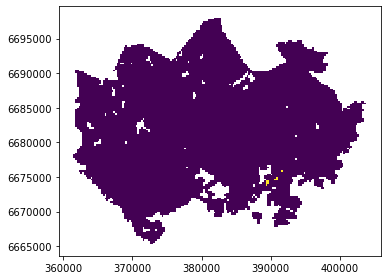

In [26]:
%matplotlib inline

import matplotlib.pyplot as plt


acc.plot(column="suitable_area", linewidth=0);

plt.tight_layout()

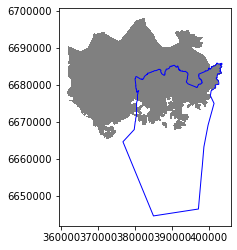

In [29]:
import geopandas as gpd
import shapely.speedups 
%matplotlib inline 

# Let's enable speedups to make queries faster
shapely.speedups.enable()

#File path
border_fp= "L4_data/Helsinki_borders.shp"
grid_fp= "L4_data/TravelTimes_to_5975375_RailwayStation.shp"

grid= gpd.read_file(grid_fp)
hel= gpd.read_file(border_fp)

#Plot Layer 
ax= grid.plot(facecolor="gray")
hel.plot(ax=ax, facecolor="None", edgecolor='blue')


In [31]:
#中心点が同じであればエラー
assert hel.crs== grid.crs, "CRS differs between layers"

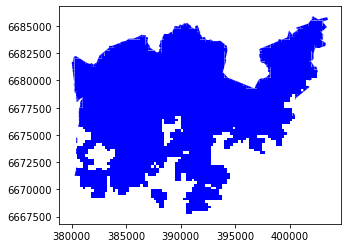

In [32]:
intersection= gpd.overlay(grid, hel, how="intersection")

intersection.plot(color="b")

In [36]:
#output file path 

outfp= "L4_data/TravelTimes_to_5975375_RailwayStation_Helsinki_intersection.shp"

intersection.to_file(outfp)

In [37]:

# Conduct the aggregation
dissolved = intersection.dissolve(by="car_r_t")

# What did we get
print(dissolved.head())

                                                  geometry  car_m_d  car_m_t  \
car_r_t                                                                        
-1       MULTIPOLYGON (((388000.000 6668750.000, 387750...       -1       -1   
 0       POLYGON ((386000.000 6672000.000, 385750.000 6...        0        0   
 7       POLYGON ((386250.000 6671750.000, 386000.000 6...     1051        7   
 8       MULTIPOLYGON (((386250.000 6671500.000, 386000...     1286        8   
 9       MULTIPOLYGON (((387000.000 6671500.000, 386750...     1871        9   

         car_r_d  from_id  pt_m_d  pt_m_t  pt_m_tt  pt_r_d  pt_r_t  pt_r_tt  \
car_r_t                                                                       
-1            -1  5913094      -1      -1       -1      -1      -1       -1   
 0             0  5975375       0       0        0       0       0        0   
 7          1051  5973739     617       5        6     617       5        6   
 8          1286  5973736     706      10   

In [38]:

print('Rows in original intersection GeoDataFrame:', len(intersection))
print('Rows in dissolved layer:', len(dissolved))

Rows in original intersection GeoDataFrame: 3826
Rows in dissolved layer: 51


In [39]:
#car_r_tが見つからない・　理由。インデックスにあるから

print(dissolved.columns)

Index(['geometry', 'car_m_d', 'car_m_t', 'car_r_d', 'from_id', 'pt_m_d',
       'pt_m_t', 'pt_m_tt', 'pt_r_d', 'pt_r_t', 'pt_r_tt', 'to_id', 'walk_d',
       'walk_t', 'GML_ID', 'NAMEFIN', 'NAMESWE', 'NATCODE'],
      dtype='object')


In [40]:
# Select only geometries that are within 15 minutes away
sel_15min = dissolved.iloc[15]


#series型で格納されている。
# See the data type
print(type(sel_15min))

# See the data
print(sel_15min.head())

<class 'pandas.core.series.Series'>
geometry    (POLYGON ((388250.0001354316 6668750.000042891...
car_m_d                                                 12035
car_m_t                                                    18
car_r_d                                                 11997
from_id                                               5903886
Name: 20, dtype: object


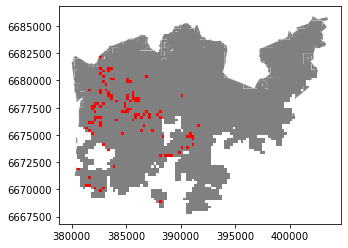

In [41]:
geo = gpd.GeoDataFrame([sel_15min.values], crs=dissolved.crs, columns=dissolved.columns)

# Plot the grid cells that are 15 minutes a way from the Railway Station
ax = dissolved.plot(facecolor='gray')
geo.plot(ax=ax, facecolor='red')